In [1]:
import pylab as plt
import hickle as hkl
import numpy as np
import glob
import pandas as pd
import h5py
import ephem
from astropy.time import Time
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS
import os

### Load all files

In [2]:
fl = sorted(glob.glob('/Volumes/JIDIJIDI/astro-data/eda-post-x/allsky_img/img*.hkl'))

df_files = {'filename': [], 'freq_idx': [], 'pol_idx': []}
for ii, fn in enumerate(fl):
    fp = os.path.basename(fn).split('-')
    df_files['filename'].append(fn)
    df_files['freq_idx'].append(int(fp[1][1:]))
    df_files['pol_idx'].append(int(fp[2][1:].split('.')[0]))


df_files = pd.DataFrame(df_files)
df_files = df_files.sort_values('freq_idx')
dsel = df_files[df_files['pol_idx'] == 0]
fl_sorted = list(dsel['filename'].values)
f_idxs = dsel['freq_idx'].values
len(fl_sorted)

11200

## Create HDF5 image cube

In [25]:
import hdf5plugin
import h5py

fn_cube = '/Volumes/JIDIJIDI/astro-data/eda-post-x/eda-channel-sweep-image-cube.h5'

### METADATA ###
# Fix frequency axis
bw = 0.925926e6      # From header.txt
f0 = 7.8125E+07      # first uvfits file FREQ, in 100/merged/...uvfits
f1 = 7.890625E+07    # second uvfits file
fc_bw = bw/32        # Fine channel bandwidth
cc_sep = f1 - f0      # coarse channel separation (oversampling)
f = np.zeros(11200, dtype='float64')
x = np.arange(11200)
for ii in range(350):
    i0, i1 = ii*32, (ii+1)*32
    f[i0:i1] = f0 - x[16]* fc_bw + x[:32] * fc_bw + cc_sep * ii
assert f[16] == f0
assert f[16+32] == f1

# Copy over other datasets
h5_metadata_path = '/Volumes/JIDIJIDI/astro-data/eda-post-x/corr_mat_metadata_v4_2020.05.20.h5'
md = h5py.File(h5_metadata_path, 'r')

dsets = {
    'dec': np.zeros(11200, dtype='float64'),
    'ra':   np.zeros(11200, dtype='float64'),
    'time': np.zeros(11200, dtype='float64'),
}
dsets['freqs'] = f

# Fill in other datasets to match shape
for ii in range(350):
    i0, i1 = (32*ii), 32*(ii + 1)
    for dsname in dsets.keys():
        dsets[dsname][i0:i1] = md[dsname][ii] 

### DATA ###
with h5py.File(fn_cube, 'r+') as h:
    for dname in dsets.keys():
        h.create_dataset(dname, data=dsets[dname])

with h5py.File(fn_cube, 'w') as h:
    ds = h.create_dataset('data', shape=(11200, 128, 128, 4), dtype='float32', 
                          chunks=(1, 128, 128, 1), **hdf5plugin.Zfp(reversible=True))

    for idx, row in df_files.iterrows():
        d = hkl.load(row['filename'])[::-1]   # Reverse required to match healpy
        ds[row['freq_idx'], :, :, row['pol_idx']] = d
        if row['freq_idx'] % 1000 == 0 and row['pol_idx'] == 0: print(f"{row['freq_idx']} / {len(df_files) // 4}")

1 / 44800
1001 / 44800
2001 / 44800
3001 / 44800
4001 / 44800
5001 / 44800
6001 / 44800
7001 / 44800
8001 / 44800
9001 / 44800
10001 / 44800
11001 / 44800


## All-sky Imager

In [206]:
def generate_skycat(observer):
    sun  = ephem.Sun()
    moon = ephem.Moon()
    sun.compute(observer)
    moon.compute(observer)

    skycat = {
        'Virgo_A': SkyCoord('12h 30m 49s', '+12:23:28', unit=('hourangle', 'degree')),
        'Hydra_A': SkyCoord('09h 18m 5.6s', '-12:5:44.0',  unit=('hourangle', 'degree')),
        'Centaurus_A':  SkyCoord('13h 25m 27.6s', '−43:01:09', unit=('hourangle', 'degree')),
        'Pictor_A': SkyCoord('05h 19m 49.721s', '−45:46:43.85', unit=('hourangle', 'degree')),
        'Hercules_A': SkyCoord('16h 51m 08.15', '+04:59:33.32', unit=('hourangle', 'degree')),
        'Fornax_A': SkyCoord('03h 22m 41.7', '−37:12:30', unit=('hourangle', 'degree')),
        'Sun': SkyCoord(sun.ra, sun.dec, unit=('rad', 'rad')),
        'Moon':  SkyCoord(moon.ra, moon.dec, unit=('rad', 'rad')),
    }
    return skycat

class AllSkyViewer(object):
    
    def __init__(self, h5path, observer=None):
        self.h5       = h5py.File(h5path, 'r')
        self.data     = self.h5['data']
        self.n_pix    = self.data.shape[1]
        self.observer = observer
        self.wcsd     = None
        self.skymodel = {}
        
        self.name = observer.name if hasattr(observer, 'name') else 'allsky'

        
        self._time  = Time(self.h5['time'][:], format='jd')
        self._freqs = self.h5['freqs'][:] / 1e6
    
    def _update_wcs(self):
        dt = Time(self._time[self._f_idx])
        self.observer.date = dt.datetime
        zen_ra, zen_dec = self.observer.radec_of(0, np.pi/2)
        
        self.wcsd = {
                 'SIMPLE': 'T',
                 'NAXIS': 2,
                 'NAXIS1': n_pix,
                 'NAXIS2': n_pix,
                 'CTYPE1': 'RA---SIN',
                 'CTYPE2': 'DEC--SIN',
                 'CRPIX1': n_pix // 2 + 1,
                 'CRPIX2': n_pix // 2 + 1,
                 'CRVAL1': np.rad2deg(zen_ra),
                 'CRVAL2': np.rad2deg(zen_dec),
                 'CDELT1': -360/np.pi / n_pix,
                 'CDELT2': 360/np.pi / n_pix  
            }
        
        self.wcs = WCS(self.wcsd)
        
    def load_skymodel(self, skymodel_dict):
        self.skymodel = skymodel_dict
    
    def new_fig(self, size=6):
        plt.figure(self.name, figsize=(size, size), frameon=False)
    
    def plot(self, f_idx, p_idx=0, sfunc=np.abs, overlay_srcs=False,  overlay_grid=True, 
                  title=None, colorbar=False, return_data=False, **kwargs):
        self._f_idx = f_idx
        self._p_idx = p_idx
                              
        d = self.data[f_idx, :, :, p_idx]
        
        self._update_wcs()
        
        plt.subplot(projection=self.wcs)
        plt.imshow(sfunc(d), **kwargs)
                              
        lst_str = str(self.observer.sidereal_time())
        title = f'{self.name}:  {self._time[f_idx].iso}  \n LST: {lst_str}  |  freq: {self._freqs[f_idx]:.2f} MHz'
        plt.title(title)
        
        if overlay_grid: 
            plt.grid(color='white', ls='dotted')
        
        if overlay_srcs:
            for src, src_sc in self.skymodel.items():
                x, y = self.wcs.world_to_pixel(src_sc)
                plt.scatter(x, y, marker='x', color='red')
                plt.text(x + 3, y + 3, src)
        if colorbar is True:
            plt.colorbar(orientation='horizontal')
        #plt.axis('off')
        if return_data:
            return d
        

In [248]:
cals = {'Pictor_A':[], 'Fornax_A':[], 'Sun':[]}

for idx in range(len(asv._freqs)):
    asv._f_idx = idx
    asv._update_wcs()
    for src, src_sc in asv.skymodel.items():
        x, y = asv.wcs.world_to_pixel(src_sc)
        cals[src].append(asv.data[:, x, y, 0])

OSError: Can't read data (file read failed: time = Thu Nov 10 21:27:12 2022
, filename = '/Volumes/JIDIJIDI/astro-data/eda-post-x/eda-channel-sweep-image-cube.h5', file descriptor = 78, errno = 5, error message = 'Input/output error', buf = 0x7fa12f581600, total read size = 3488, bytes this sub-read = 3488, bytes actually read = 18446744073709551615, offset = 5056)

In [244]:
x, y = np.split(np.round(np.array(pix_ids['Fornax_A'])).astype('int32'), 2, axis=1)
w = np.arange(11200, dtype='int32')
z = 0

In [247]:
asv.data[w]

OSError: Can't read data (file read failed: time = Thu Nov 10 21:24:59 2022
, filename = '/Volumes/JIDIJIDI/astro-data/eda-post-x/eda-channel-sweep-image-cube.h5', file descriptor = 78, errno = 5, error message = 'Input/output error', buf = 0x7f9fcbb75a00, total read size = 3488, bytes this sub-read = 3488, bytes actually read = 18446744073709551615, offset = 5056)

In [207]:
# Initialize EDA array
eda = ephem.Observer()
eda.lat = lat
eda.lon = lon
eda.elev = elev
eda.date = t[0].datetime
eda.name = 'EDA2'

skycat = generate_skycat(eda)
srcs = {}
for src in ['Pictor_A', 'Fornax_A', 'Sun']:
    srcs[src] = skycat[src]

asv = AllSkyViewer(fn_cube)
asv.observer = eda
asv.name     = eda.name
asv.load_skymodel(srcs)

In [199]:
np.round(f[32-5:32+5].reshape((2, 5)), 4)

array([[78443287.0625, 78472222.25  , 78501157.4375, 78530092.625 ,
        78559027.8125],
       [78443287.    , 78472222.1875, 78501157.375 , 78530092.5625,
        78559027.75  ]])

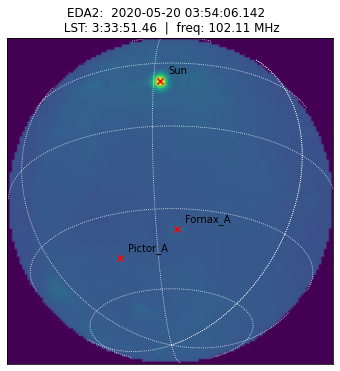

In [212]:
asv.new_fig()
d = asv.plot(1000, overlay_srcs=True, return_data=True)

In [202]:
f'{100:04}'

'0100'

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and pos

2600
2700


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and pos

2800
2900
3000


KeyboardInterrupt: 

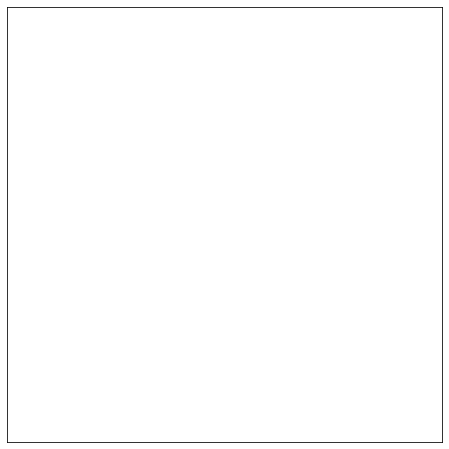

In [213]:
asv.new_fig(size=8)
for ii in range(0, 4000):
    asv.plot(ii, overlay_srcs=True)
    plt.savefig(f"img/movie-{ii:04}.png")
    plt.clf()
    if ii % 100 == 0: print(ii)

In [ ]:
cals = {
    'pictor_A': [],
    'fornax_A': [],
    'sun': [],
}

for f_idx, fn in zip(f_idxs, fl_sorted):
    d = hkl.load(fn)[::-1]
    f = f_mhz[f_idx]
    gsm.date = t[f_idx // 32].datetime
    sun.compute(gsm)
    for src in ['pictor_A', 'fornax_A', 'sun']:
        x, y = wcs.world_to_pixel(skymodel[src])
        x, y = int(np.round(x)), int(np.round(y))
        cals[src].append(d[y, x])
    
    #sky = gsm.generate(f)
    #gsm_sky = hp.orthview(sky, half_sky=True, return_projected_map=True)
    #gsm_sky_r = resize(gsm_sky, output_shape=(128, 128))
    plt.close()
    #out = minimize(residual, params)
    #cals['gcal'].append(out.params['m'])
    if f_idx % 32 == 0 : print(f_idx)

### Plot files

In [217]:
import pygdsm
import healpy as hp
gsm = pygdsm.GlobalSkyModel()

In [215]:
sky = gsm.generate(np.arange(50, 200))

In [220]:
skycat['Fornax_A'].galactic.l

<Longitude 240.16303243 deg>

In [228]:
hp.npix2nside(len(sky[0]))

512

In [230]:
hp.ang2pix(512, skycat['Fornax_A'].galactic.l.value, skycat['Fornax_A'].galactic.b.value, lonlat=True)

2886768

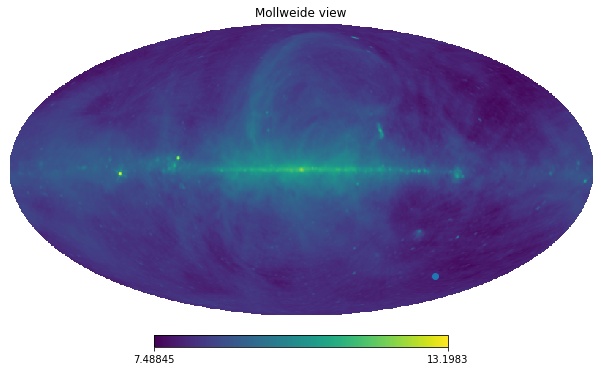

In [234]:
hp.mollview(np.log(sky[0]))
hp.projscatter(skycat['Fornax_A'].galactic.l.value, skycat['Fornax_A'].galactic.b.value, lonlat=True)

In [16]:


from skimage.transform import resize
gsm = pygdsm.GSMObserver()
gsm.lat = lat
gsm.lon = lon
gsm.elev = elev
gsm.date = t.datetime[0]
sky = gsm.generate(f_mhz[0])

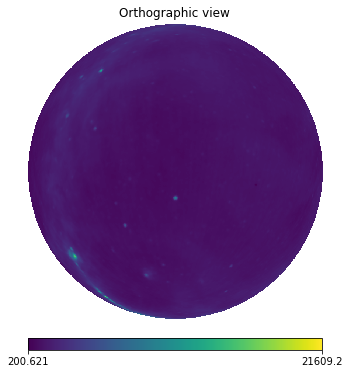

In [471]:
gsm_sky = hp.orthview(sky, half_sky=True, return_projected_map=True)
gsm_sky_r = resize(gsm_sky, output_shape=(128, 128))

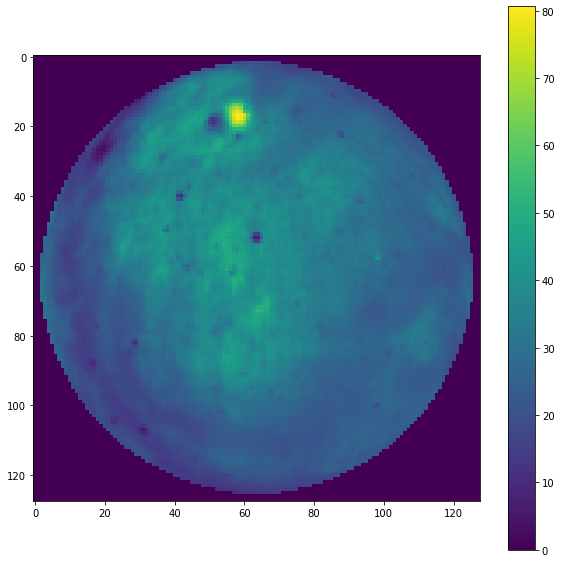

In [474]:
plt.figure(figsize=(10, 10))
plt.imshow(d / gsm_sky_r)
plt.colorbar()

In [485]:
mask = np.isinf(gsm_sky_r)
d[mask]

array([0., 0., 0., ..., 0., 0., 0.])

In [491]:
from lmfit import minimize, Parameters, fit_report

def residual(params):
    m = params['m']
    #b = params['b']
    mask = ~np.isinf(gsm_sky_r)
    model = m * gsm_sky_r[mask]
    data = d[mask]

    return (data - model)


params = Parameters()
params.add('m', value=40)
#params.add('b', value=1)

out = minimize(residual, params)

print(fit_report(out))

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 4
    # data points      = 11900
    # variables        = 1
    chi-square         = 1.9388e+12
    reduced chi-square = 1.6294e+08
    Akaike info crit   = 225016.689
    Bayesian info crit = 225024.073
[[Variables]]
    m:  24.1573404 +/- 0.08046863 (0.33%) (init = 40)


In [495]:
d_cal = d / out.params['m']

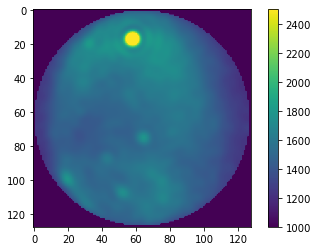

In [502]:
plt.imshow(d_cal, vmin=1000, vmax=2500)
plt.colorbar()

In [35]:
cals = {
    'pictor_A': [],
    'fornax_A': [],
    'sun': [],
}

for f_idx, fn in zip(f_idxs, fl_sorted):
    d = hkl.load(fn)[::-1]
    f = f_mhz[f_idx]
    gsm.date = t[f_idx // 32].datetime
    sun.compute(gsm)
    for src in ['pictor_A', 'fornax_A', 'sun']:
        x, y = wcs.world_to_pixel(skymodel[src])
        x, y = int(np.round(x)), int(np.round(y))
        cals[src].append(d[y, x])
    
    #sky = gsm.generate(f)
    #gsm_sky = hp.orthview(sky, half_sky=True, return_projected_map=True)
    #gsm_sky_r = resize(gsm_sky, output_shape=(128, 128))
    plt.close()
    #out = minimize(residual, params)
    #cals['gcal'].append(out.params['m'])
    if f_idx % 32 == 0 : print(f_idx)

0
32
64
96
160
192
288
320
352
480
544
576
608
640
672
704
832
864
896
960
1024
1056
1088
1152
1216
1248
1280
1376
1408
1472
1536
1568
1600
1664
1696
1760
1824
1856
1888
1920
1952
1984
2016
2048
2144
2208
2240
2272
2304
2336
2400
2432
2464
2560
2592
2656
2784
2816
2848
2912
2944
2976
3008
3072
3104
3136
3232
3328
3392
3424
3456
3488
3584
3616
3648
3712
3744
3776
3808
3872
3904
3968
4032
4064
4096
4160
4192
4224
4256
4288
4352
4384
4416
4480
4544
4576
4640
4672
4832
4864
4896
4992
5024
5152
5280
5312
5344
5376
5408
5472
5504
5536
5568
5600
5632
5728
5824
5856
5888
6016
6048
6080
6112
6144
6176
6208
6272
6336
6368
6400
6432
6464
6496
6592
6656
6688
6720
6752
6784
6816
6848
6912
6944
7008
7072
7104
7168
7200
7232
7264
7328
7360
7392
7424
7456
7488
7552
7648
7680
7712
7744
7776
7808
7840
7904
7936
7968
8000
8032
8064
8128
8160
8192
8224
8256
8320
8352
8384
8448
8480
8512
8576
8608
8640
8704
8736
8768
8800
8864
8896
8992
9024
9088
9120
9152
9184
9216
9248
9280
9344
9376
9408
9440
9504
9568


(110.0, 135.0)

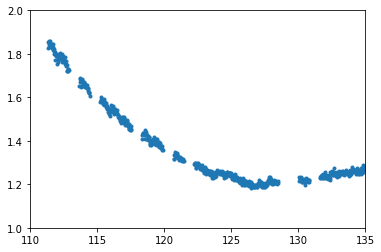

In [36]:
plt.plot(f_mhz[f_idxs], np.array(cals['sun']) / np.array(cals['fornax_A']), '.')
plt.ylim(1, 2)
plt.xlim(110, 135)


In [37]:
np.argmin(np.abs(f_mhz - 123))

1854

In [118]:
l = np.linspace(1, -1, n_pix)
m = np.linspace(1, -1, n_pix)
grid = np.zeros((n_pix, n_pix), dtype='float64')
lg, mg = np.meshgrid(l, m)
lm2g = lg**2 + mg**2
sqrt_lm2g = np.sqrt(1 - lm2g)

/var/folders/n3/pbwrsp713bd28_l4xt61c7zh0000gn/T/ipykernel_91664/3441365582.py:6: RuntimeWarning: invalid value encountered in sqrt
  sqrt_lm2g = np.sqrt(1 - lm2g)


In [120]:
def make_image(self, n_pix=128):

    l = np.linspace(1, -1, n_pix)
    m = np.linspace(1, -1, n_pix)

    grid = np.zeros((n_pix, n_pix), dtype='float64')
    for xx in range(n_pix):
        for yy in range(n_pix):
            lm2 = l[xx]**2 + m[yy]**2
            if lm2 < 1:
                pvec = np.array((l[xx], m[yy], np.sqrt(1 - lm2)))
                #self._point_vec(pvec)
                grid[yy, xx] = 0#np.abs(self.beamform())
    return grid

def make_image2(self, n_pix=128):
    grid = np.zeros((n_pix, n_pix), dtype='float64')
    for xx in range(n_pix):
        for yy in range(n_pix):
            if sqrt_lm2g[xx, yy] < 1:
                pvec = np.array((lg[xx, yy], mg[xx,yy], sqrt_lm2g[xx, yy]))
                #self._point_vec(pvec)
                grid[yy, xx] = 0 #np.abs(self.beamform())
    return grid

%timeit make_image(0)

45.9 ms ± 1.87 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [121]:
%timeit make_image2(0)

21.5 ms ± 524 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [122]:
import numba

In [123]:
from numba import njit, prange

@njit(parallel=True)
def prange_test(A):
    s = 0
    # Without "parallel=True" in the jit-decorator
    # the prange statement is equivalent to range
    for i in prange(A.shape[0]):
        s += A[i]
    return s

In [124]:
A = np.arange(1000)

In [126]:
%timeit prange_test(A)

80.7 µs ± 16.8 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
